In http://localhost:8891/notebooks/caribbean_disaster_risk/03_1_1_result_qc.ipynb we see a relatively low number of 'concrete', 'incomple' and 'other' roof types

Here we boost these numbers.

NB just sharpening all blurred over theshold of 100 in 05_1_fastai_train_resnet_20191027.ipynb led to slightly worse results

#### Env: 
    
    Use solaris conda env

In [1]:
from PIL import Image, ImageOps, ImageFilter
import cv2
from pathlib import Path
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from skimage import data
from skimage.filters import unsharp_mask
from skimage.io import imread
import numpy as np
import os

from imutils import paths
import argparse
import cv2
import shutil
import imgaug
from imgaug import augmenters as iaa
import pandas as pd

In [2]:
data_dir = Path('data')

NB is re-run for different padding types

In [3]:
img_size=256

In [4]:

#BORDER_REFLECT_101
border='reflect'
#BORDER_WRAP
#border='wrap'

In [5]:
#clipped, rotated and reflected images
train_images = data_dir/f'train/rotated/clipped/{border}/{img_size}'
test_images = data_dir/f'test/rotated/clipped/{border}/{img_size}'
balanced_dir = data_dir/f'train/rotated/clipped/{border}/{img_size}/balanced'
balanced_dir.mkdir(exist_ok=True)
balanced_dir = data_dir/f'train/rotated/clipped/{border}/{img_size}/balanced/valid'
balanced_dir.mkdir(exist_ok=True)

In [6]:
fnames = [f for f in listdir(train_images) if isfile(join(train_images, f))]
tnames = [f for f in listdir(test_images) if isfile(join(test_images, f))]

In [7]:
fnames[0]

'7a2e083e.tif'

In [8]:
df_all = pd.read_csv(data_dir/'df_train_all.csv')

In [9]:
df_valid=df_all.loc[df_all['verified'] == True]

In [10]:
tot=len(df_valid)

In [11]:
df_valid['roof_material'].value_counts()

healthy_metal      7381
irregular_metal    5241
concrete_cement    1387
incomplete          668
other               193
Name: roof_material, dtype: int64

In [12]:
#low_qty=['irregular_metal','concrete_cement', 'incomplete','other']
#df_not_healthy_metal=df_valid.loc[df_valid['roof_material'].isin(low_qty)]

In [13]:
other_frac=193/tot

In [14]:
1/other_frac

77.04663212435233

In [15]:
incomplete=668/tot

In [16]:
1/incomplete

22.26047904191617

In [17]:
concrete_cement=1387/tot

In [18]:
1/concrete_cement

10.720980533525594

In [19]:
irregular_metal=5241/tot

In [20]:
1/irregular_metal

2.8372448006105704

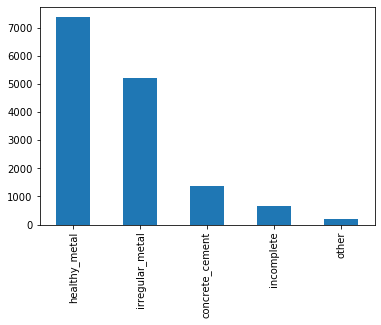

In [21]:
df_valid['roof_material'].value_counts().plot(kind='bar')

In [22]:
def mpl_show(new_im, label, title=''):
    plt.imshow(new_im, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    text = label+' '+title
    plt.title(text)
    plt.show()
    plt.close()

In [23]:
def mpl_2_plot(im1, title1, im2, title2):
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(im1)
    plt.title(title1, size=12)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(im2)
    plt.title(title2, size=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()  

In [24]:
def pil_unsharp(image, radius, percent):
    im = Image.open(image)
    im1 = im.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent))
    return im1

### Bluriness calculation
Some images are clearly blurry, lets see if we can identify these
see https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

In [25]:
#focus measures that fall below this value will be considered 'blurry'
threshold=50.0

In [26]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [27]:
def calc_bluriness(images):
    image_quality={}
    i=0
    for imagePath in images:
        # load the image, convert it to grayscale, and compute the
        # focus measure of the image using the Variance of Laplacian
        # method
        if imagePath.endswith('.tif'):
            image = cv2.imread(imagePath)
            try:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                fm = variance_of_laplacian(gray)
                text = "Not Blurry"

                # if the focus measure is less than the supplied threshold,
                # then the image should be considered "blurry"
                if fm < threshold:
                    text = "Blurry"
                id=str(Path(imagePath).name).split('.')[0]
                image_quality[id]=text
                if i<50:
                    mpl_show(image, id, text)
                i+=1
            except Exception as e:
                print(f'error with {imagePath}')
    return image_quality

In [28]:
#non_hm=list(df_not_healthy_metal['id'])

In [29]:
all_im=list(df_valid['id'])

In [30]:
all_images=[]
for n in all_im:
    p=data_dir/f'train/rotated/clipped/{border}/256/'
    p=p.absolute()
    p=str(p)+'/'+n+'.tif'
    all_images.append(p)

In [31]:
#non_hm[:1]

In [32]:
#nhm_images=[]
#for n in non_hm:
#    p=data_dir/f'train/rotated/clipped/{border}/256/'
#    p=p.absolute()
#    p=str(p)+'/'+n+'.tif'
#    nhm_images.append(p)

In [33]:
#nhm_images[0]

In [34]:
image_quality=calc_bluriness(all_im)

In [35]:
len(image_quality.keys())

0

see Hands-On-Image-Processing-with-Python-master/Chapter5.ipynb

In [36]:
def pil_unsharp(image, radius, percent):
    im = Image.open(image)
    im1 = im.filter(ImageFilter.UnsharpMask(radius=radius, percent=percent))
    return im1

In [37]:
def skimage_unsharp_mark(img, radius, ammount):
    im = imread(img)
    im1 = unsharp_mask(im, radius=radius, amount=ammount)
    return im1

Unsharpen mask in PIL looks to be doing a better job than skimage 

In [38]:
def img_type_av_sz(fn_list):
    widths = []
    heights = []
    for im in fn_list:
        #100 x faster than open_image(img_f)
        if str(im).endswith('.tif'):
            w,h=Image.open(im).size
            widths.append(w)
            heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')
    return widths, heights

In [39]:
f_names = [data_dir/f'train/rotated/clipped/{border}/256/{f}' for f in listdir(data_dir/f'train/rotated/clipped/{border}/256/') if isfile(join(data_dir/f'train/rotated/clipped/{border}/256/', f))]

In [40]:
widths, heights=img_type_av_sz(f_names)

avg width: 256.0, avg height: 256.0, max w: 256, min w: 256, max h: 256, min h: 256


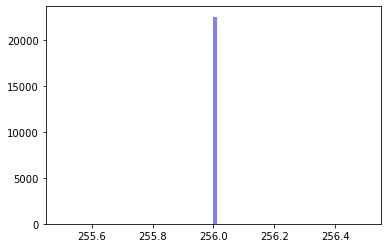

In [41]:
num_bins = 100
n, bins, patches = plt.hist(widths, num_bins, facecolor='blue', alpha=0.5)
plt.show()

### sharpen  blurry non healthy metal

In [42]:
radius=2
percent=150
for k, v in image_quality.items():
    if v=='Blurry':
        sharp_im=pil_unsharp(train_images/f'{k}.tif',radius,percent)
        sharp_im.save(train_images/f'balanced/valid/{k}_sharp.tif')

In [43]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.5), # vertically flip 50% of all images
    iaa.Crop(percent=(0, 0.05)), # random crops
    iaa.SomeOf((0, 5),
        [
            iaa.Sometimes(0.1,
                iaa.GaussianBlur(sigma=(0, 0.1))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.Sometimes(0.1, iaa.ContrastNormalization((0.9, 1.1))),
            iaa.Sometimes(0.05, iaa.CropAndPad(percent=(0, 0.1))), 
            iaa.Sometimes(0.1, iaa.Add((-20, 20))),
            iaa.Sometimes(0.1, iaa.Sharpen(alpha=(0.0, 0.1))),
            iaa.Sometimes(0.1, iaa.AdditiveGaussianNoise(scale=(0.0, 0.01*255))),
            iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05)),
                ])

        ],
        random_order=True)
    ],
    random_order=True)

/home/walle/miniconda3/envs/solaris/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [44]:
def apply_imgur(imgfiles, mul):
    img_shape = (256,256)

    #we need to do this n times
    for mc in range(int(mul)):
        X = np.zeros([len(imgfiles), img_shape[0], img_shape[1], 3], dtype=np.uint8)
        fnames=[]
        for index,f in enumerate(imgfiles):
            fname=f.split('.tif')[0]
            im = Image.open(f)
            X[index,:] = np.array(im)[:,:,0:3]
            fnames.append(fname)
        images_aug = seq.augment_images(X)
        dir_pth=data_dir/f'train/rotated/clipped/{border}/256/imgaug/'
        print(f'augmenting {len(images_aug)} images to {dir_pth}')
        assert len(images_aug)==len(fnames)
        if not os.path.exists(dir_pth):
            os.makedirs(dir_pth)
        ij = 0
        for b,f in zip(images_aug, fnames):
            im = Image.fromarray(b)
            im.save(dir_pth/f'{f}_imgaug_{mc}_{ij}.tif')
            ij+=1

In [46]:
apply_imgur(all_images, 10)

augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug
augmenting 14870 images to data/train/rotated/clipped/reflect/256/imgaug


In [47]:
#apply_imgur(all_images, 1)

In [48]:
imgaug_names = [f for f in listdir(data_dir/f'train/rotated/clipped/{border}/256/') if 'imgaug' in f]

In [49]:
imgaug_names[0]

'7a234dfe_imgaug_3_3359.tif'

In [50]:
df_all.head()

,id,roof_material,verified,country,region
0,7a3f2a10,concrete_cement,True,colombia,borde_rural
1,7a1f731e,irregular_metal,True,colombia,borde_rural
2,7a424ad8,healthy_metal,True,colombia,borde_rural
3,7a3edc5e,healthy_metal,True,colombia,borde_rural
4,7a303a6e,healthy_metal,True,colombia,borde_rural


In [51]:
aug=[]
for f in imgaug_names:
    n=f.split('_')[0]
    aug.append(n)

In [52]:
augmented=list(set(aug))

In [53]:
augmented[0]

'7a34eb5e'

In [54]:
df_aug=df_all.copy()

In [55]:
imgaug_names[0]

'7a234dfe_imgaug_3_3359.tif'

Create new df containing non and augmented copies of images

In [56]:
for i,f in enumerate(imgaug_names):
    if (i%1000)==0:
        print(i)
    n=f.split('_')[0]
    row=df_all.loc[df_all['id'] == n]
    d=row.reset_index().to_dict(orient='records')
    if len(d)>0:
        d=d[0]
        t=f.split('.tif')[0]
        d['id']=t
        del d['index']
        df_aug=df_aug.append(d, ignore_index=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000


In [58]:
df_aug.tail()

,id,roof_material,verified,country,region
234439,7a4098d2_imgaug_5_10762,healthy_metal,True,guatemala,mixco_1_and_ebenezer
234440,7a2a075c_imgaug_7_6930,irregular_metal,True,colombia,borde_soacha
234441,7a3b9b16_imgaug_9_3308,healthy_metal,True,colombia,borde_rural
234442,7a4492a2_imgaug_3_7806,healthy_metal,True,colombia,borde_soacha
234443,7a39172e_imgaug_5_9325,irregular_metal,True,colombia,borde_soacha


In [59]:
len(df_aug)

234444

In [60]:
df_aug=df_aug.drop_duplicates(subset=['id'])

In [61]:
len(df_aug)

171253

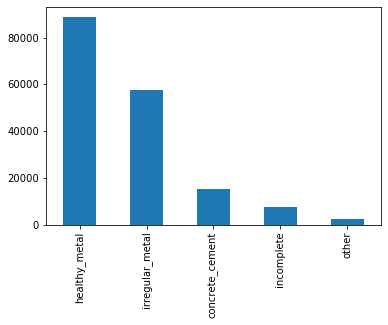

In [62]:
df_aug['roof_material'].value_counts().plot(kind='bar')

In [63]:
df_aug.to_csv(data_dir/f'df_aug_{border}.csv', index=False)

In [64]:
im1=Image.open(data_dir/f'train/rotated/clipped/{border}/256/7a44ca24.tif')
im2=Image.open(data_dir/f'train/rotated/clipped/{border}/256/7a44ca24_imgaug_0_3237.tif')
im3=Image.open(data_dir/f'train/rotated/clipped/{border}/256/7a44ca24_imgaug_1_3237.tif')
im4=Image.open(data_dir/f'train/rotated/clipped/{border}/256/7a44ca24_imgaug_2_3237.tif')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/rotated/clipped/reflect/256/7a44ca24_imgaug_0_3237.tif'

In [ ]:
mpl_2_plot(im1, 'actual', im2, 'aug_0')

In [ ]:
mpl_2_plot(im1, 'actual', im3, 'aug_1')

In [ ]:
mpl_2_plot(im1, 'actual', im4, 'aug_2')